In [ ]:
import os
os.system("export PYSYN_CDBS=''/home/kiran/kurucz_models/grp/hst/cdbs/'")
# or
# export PYSYN_CDBS=/media/kiran/New Volume/SEM_6/Internship/kurucz_models/grp/hst/cdbs/
# Run the above line in the command prompt before using this code ... open terminal in folder kurucz_models and type this

import numpy as np
import matplotlib.pyplot as plt
import time
from astropy.io import fits
#import spectres
from scipy.stats import chisquare
from scipy import stats
from astropy import units as u
from astropy import constants as const
import pysynphot as S
import spectres
import csv
import scipy.integrate as integrate
from PyAstronomy import pyasl

/home/kiran/.local/lib/python3.6/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /home/kiran/kurucz_models/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/home/kiran/.local/lib/python3.6/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /home/kiran/kurucz_models/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/home/kiran/.local/lib/python3.6/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /home/kiran/kurucz_models/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


In [ ]:
def reduced_chi_square(x,y,s,m): # ddof = v
    v = x.size - m
    chi2 = (np.sum((x-y)**2/s**2))/v
    p = 1 - stats.chi2.cdf(chi2, v)
    return chi2,p

def get_photometric_flux(m_wave,interpolated_flux,F):
    for X in list(F.keys()):
        w = []
        Sx = []
        with open("Bessel_{}-1.txt".format(X),'r') as f:
            for line in f:
                y = line.split()
                if(y[0] == '#cumulative'):
                    cumulative_sum = float(y[-1])
                elif(y[0] == '</div>'):
                    break
                else:
                    y = [float(i) for i in line.split()]
                    w.append(y[0]*(10)) # for converting nm to A
                    Sx.append(y[1])
        w = np.array(w[::-1])
        Sx = np.array(Sx[::-1])
        wave = np.array(list(set().union(w,m_wave)))
        wave = np.sort(wave)
        idx = np.where(np.logical_and(wave>=1000, wave<=100000))
        wave = wave[idx]
        interpolated_Sx = np.interp(wave, w, Sx)
        interpolated_m_flux = np.interp(wave, m_wave, interpolated_flux)
        F[X] = integrate.simps(interpolated_Sx*interpolated_m_flux, wave)/integrate.simps(interpolated_Sx, wave)
    return F

In [ ]:
U = [3200,4000]
B = [4000,5000]
V = [5000,7000]
R = [5500,8000]
I = [7000,9000]
######### USER INPUTS ########
savefig  = False
filename = 'ukk5v'
data_directory = "./ESO_spectral_type/"
form = '.fits'
flux_error_data = False
##############################

wavelength_range = [1000,100000]
s_wave = []
s_flux = []
s_wave, s_flux = pyasl.read1dFitsSpec(data_directory+filename+form)

del_arr = np.where(s_flux<=0)
s_flux = np.delete(s_flux,del_arr,0)
s_wave = np.delete(s_wave,del_arr,0)

best_r = 0
best_log_g = 0
best_teff = 0
best_met = 0
plt.plot(s_wave,s_flux)
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux (Arbitrary units)")

Best fit model parameters: 
Log(g) = 4.9 [0.05]
Teff = 4200 [50] 
[Fe/H] = log_10((Fe/H)star/(Fe/H)sun) = -1.0 [0.05] 
Md = 6.57729173533118e-07 
Chi-square value = 13.15855625544016 
p value = 1.0
Percentage Mean Residual Value = 33.31879373358903 %


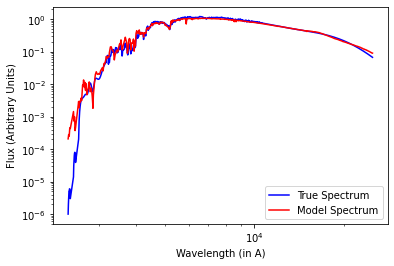

In [279]:
#log_g = np.arange(0,5,1)
#teff = np.arange(3500,10500,2000)
#met = np.arange(-2.5,0.5,0.5)
#Rad = np.array([1,0.1,0.01])

log_g = np.array([4.9])
teff = np.array([4200])
met = np.array([-1.0])
Md = 0
savefig = False

chi = np.inf
p = 0
for t in teff:
    for g in log_g:
        for m in met:
            try:
                sp = S.Icat('ck04models', t, m, g)
            except:
                continue
            m_wave = sp.wave
            m_flux = sp.flux
            idx = np.where(np.logical_and(m_wave>=wavelength_range[0], m_wave<=wavelength_range[1])) # considering particular frequency range                            
            m_wave = m_wave[idx]
            m_flux = m_flux[idx]

            s_lower_lim = np.argmin(np.abs(s_wave - m_wave[0]))
            s_upper_lim = np.argmin(np.abs(s_wave - m_wave[-1]))

            m_lower_lim = np.argmin(np.abs(m_wave - np.floor(s_wave[0])))
            m_upper_lim = np.argmin(np.abs(m_wave - np.ceil(s_wave[-1])))

            if(m_wave[m_upper_lim] < s_wave[-1]):
                m_wave = m_wave[m_lower_lim:m_upper_lim+2]
                m_flux = m_flux[m_lower_lim:m_upper_lim+2]    
            else:
                m_wave = m_wave[m_lower_lim:m_upper_lim+1]
                m_flux = m_flux[m_lower_lim:m_upper_lim+1]

            s_wave = s_wave[s_lower_lim:s_upper_lim+1]
            s_flux = s_flux[s_lower_lim:s_upper_lim+1]

            if(flux_error_data):
                if(m_wave.size > s_wave.size):
                    s_flux_e = s_flux_e[s_lower_lim:s_upper_lim+1]
                    interpolated_flux, interpolated_flux_e = spectres.spectres(m_wave, s_wave, s_flux, s_flux_e)
                    Md = np.median(s_flux/interpolated_flux)
                    interpolated_flux = interpolated_flux*Md

                    if(reduced_chi_square(s_flux,interpolated_flux,interpolated_flux_e,4)[0] < chi):
                        chi,p = reduced_chi_square(s_flux,interpolated_flux, interpolated_flux_e,4)
                        best_r = r
                        best_log_g = g
                        best_teff = t
                        best_met = m

                    s_wave = s_wave[:m_wave.size]
                    s_flux = s_flux[:m_wave.size]
                else:
                    s_flux_e = s_flux_e[s_lower_lim:s_upper_lim+1]
                    interpolated_flux = np.interp(s_wave, m_wave, m_flux)
                    Md = np.median(s_flux/interpolated_flux)
                    interpolated_flux = (interpolated_flux*Md).value

                    if(reduced_chi_square(s_flux,interpolated_flux,s_flux_e,4)[0] < chi):
                        chi,p = reduced_chi_square(s_flux,interpolated_flux, s_flux_e,4)
                        best_r = r
                        best_log_g = g
                        best_teff = t
                        best_met = m
                    m_wave = s_wave
                    m_flux = interpolated_flux/Md

            else:
                if(s_wave.size > m_wave.size):
                    interpolated_flux = np.interp(s_wave, m_wave, m_flux)
                    Md = np.mean([np.median(s_flux/interpolated_flux),np.mean(s_flux/interpolated_flux)])
                    interpolated_flux = interpolated_flux*Md

                    if(chisquare(s_flux,interpolated_flux)[0] < chi):
                        chi,p = chisquare(s_flux,interpolated_flux)
                        #best_r = r
                        best_log_g = g
                        best_teff = t
                        best_met = m
                    m_wave = s_wave
                    m_flux = interpolated_flux/Md
                else:
                    interpolated_flux = np.interp(m_wave, s_wave, s_flux)
                    Md = np.median(s_flux/interpolated_flux)
                    s_flux = np.copy(interpolated_flux)

                    if(chisquare(s_flux,interpolated_flux)[0] < chi):
                        chi,p = chisquare(s_flux,interpolated_flux)
                        #best_r = r
                        best_log_g = g
                        best_teff = t
                        best_met = m
                    interpolated_flux = m_flux*Md
                    s_wave = m_wave

interpolated_flux /= Md
Md *= 1.0 # fudge factor
interpolated_flux *= Md
chi,p = chisquare(s_flux,interpolated_flux)
print("Best fit model parameters: \nLog(g) = {} [{}]\nTeff = {} [{}] \n[Fe/H] = log_10((Fe/H)star/(Fe/H)sun) = {} [{}] \nMd = {} \nChi-square value = {} \np value = {}".format(best_log_g,0.05,best_teff,50,best_met,0.05,Md,chi,p))
print("Percentage Mean Residual Value = {} %".format(np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100)))


plt.loglog(s_wave,s_flux,'b')
plt.loglog(m_wave,m_flux*Md,'r')
#plt.loglog(s_wave,s_flux+s_flux_e,'--b')
#plt.loglog(s_wave,s_flux-s_flux_e,'--b')
plt.xlabel("Wavelength (in A)")
plt.ylabel("Flux (Arbitrary Units)")
plt.legend(["True Spectrum","Model Spectrum"])

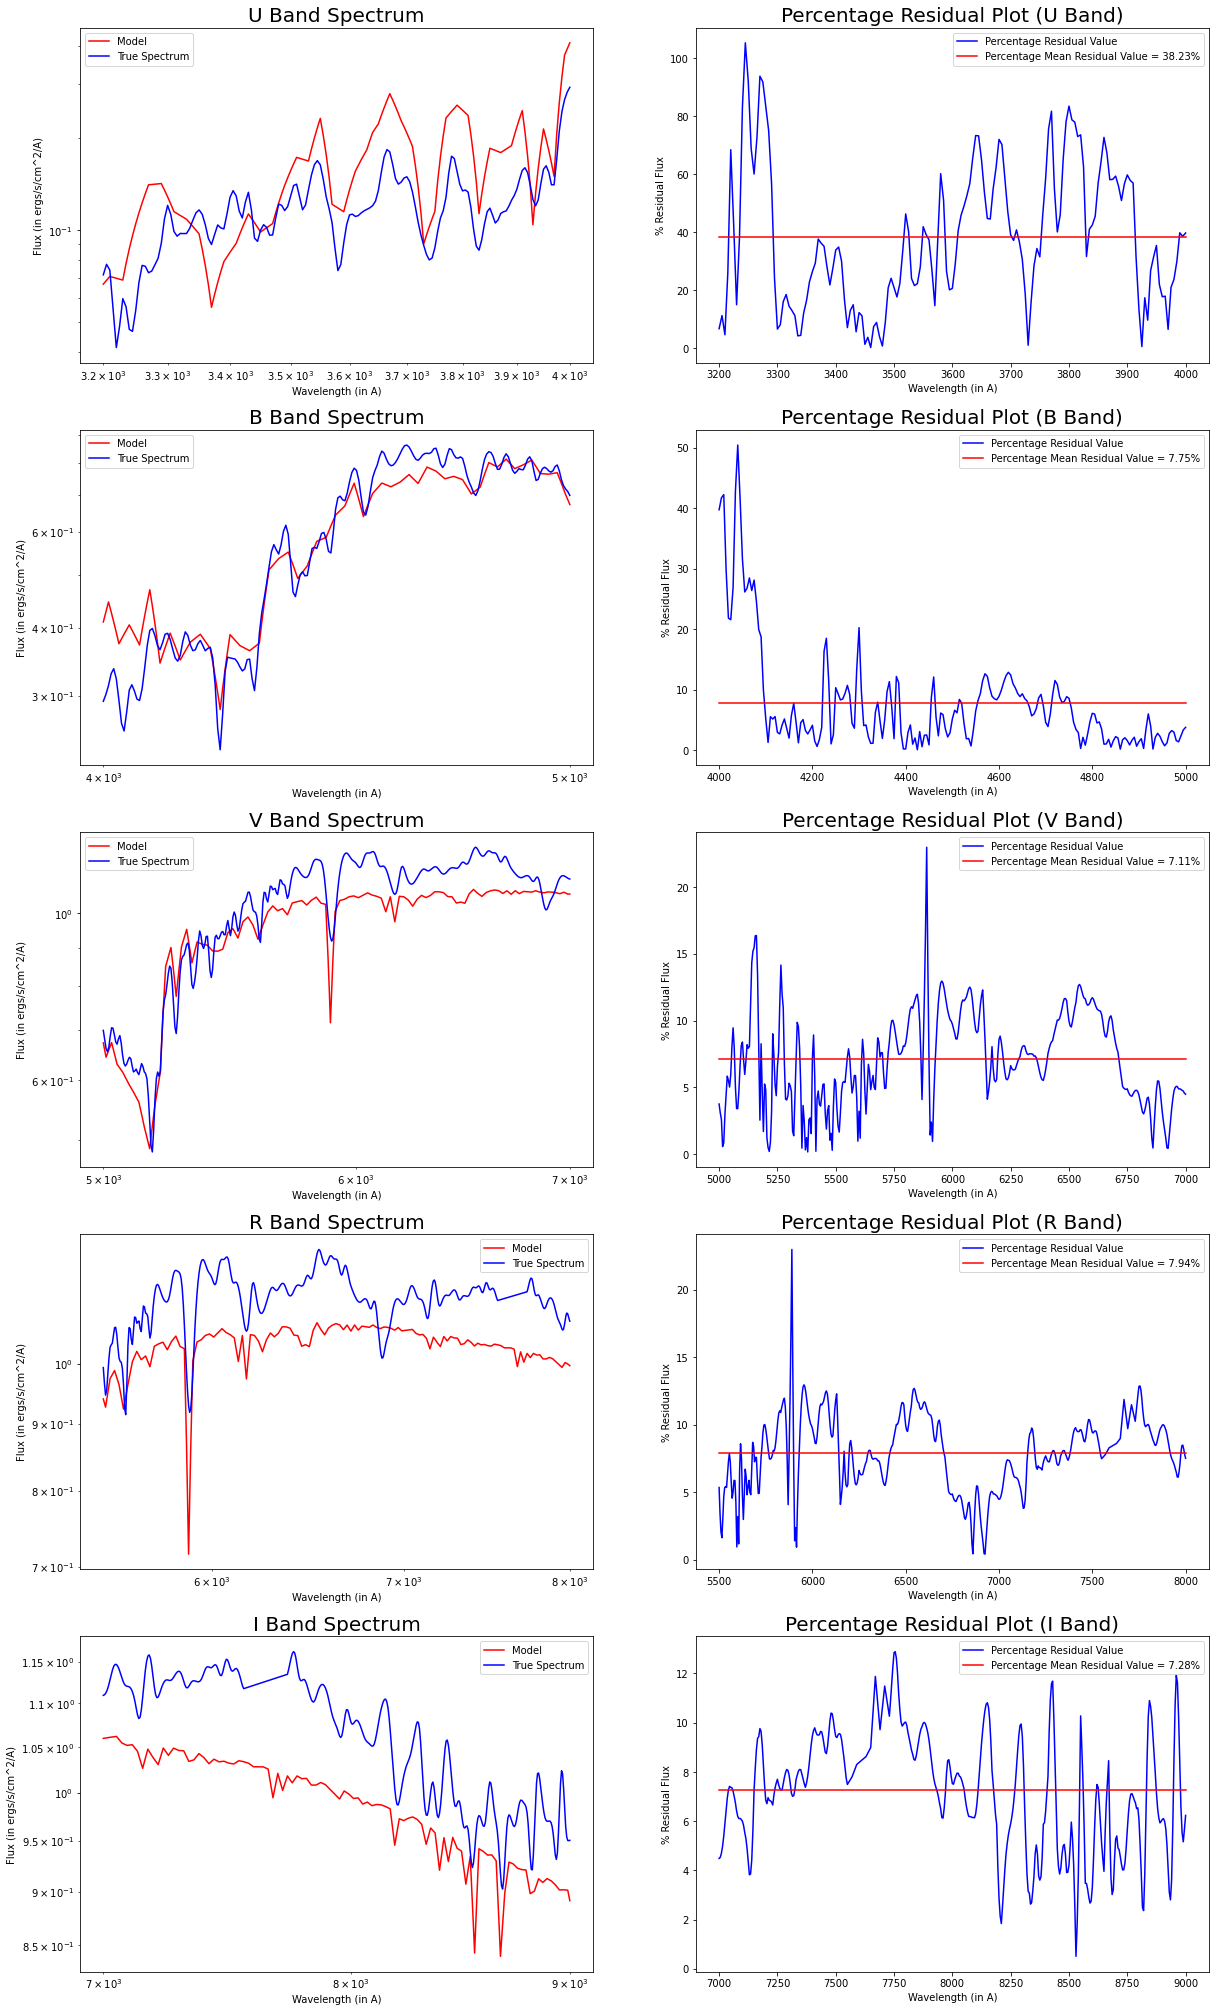

In [280]:
t_f = 20
n_row = 5
n_col = 2
fig = plt.figure(figsize=(8 * n_col, 6 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)

ax = fig.add_subplot(n_row, n_col, 1)
idx = np.where(np.logical_and(s_wave>=U[0], s_wave<=U[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
#plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
#plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in A)")
plt.ylabel("Flux (in ergs/s/cm^2/A)")
plt.legend(["Model","True Spectrum"])
plt.title("U Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 2)
idx = np.where(np.logical_and(m_wave>=U[0], m_wave<=U[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
plt.xlabel("Wavelength (in A)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot (U Band)",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])

ax = fig.add_subplot(n_row, n_col, 3)
idx = np.where(np.logical_and(s_wave>=B[0], s_wave<=B[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
#plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
#plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in A)")
plt.ylabel("Flux (in ergs/s/cm^2/A)")
plt.legend(["Model","True Spectrum"])
plt.title("B Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 4)
idx = np.where(np.logical_and(m_wave>=B[0], m_wave<=B[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
plt.xlabel("Wavelength (in A)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot (B Band)",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])

ax = fig.add_subplot(n_row, n_col, 5)
idx = np.where(np.logical_and(s_wave>=V[0], s_wave<=V[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
#plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
#plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in A)")
plt.ylabel("Flux (in ergs/s/cm^2/A)")
plt.legend(["Model","True Spectrum"])
plt.title("V Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 6)
idx = np.where(np.logical_and(m_wave>=V[0], m_wave<=V[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
#plt.loglog(m_wave,m_flux*Md,'g')
plt.xlabel("Wavelength (in A)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot (V Band)",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])

ax = fig.add_subplot(n_row, n_col, 7)
idx = np.where(np.logical_and(s_wave>=R[0], s_wave<=R[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
#plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
#plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in A)")
plt.ylabel("Flux (in ergs/s/cm^2/A)")
plt.legend(["Model","True Spectrum"])
plt.title("R Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 8)
idx = np.where(np.logical_and(m_wave>=R[0], m_wave<=R[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
#plt.loglog(m_wave,m_flux*Md,'g')
plt.xlabel("Wavelength (in A)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot (R Band)",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])

ax = fig.add_subplot(n_row, n_col, 9)
idx = np.where(np.logical_and(s_wave>=I[0], s_wave<=I[1]))
plt.loglog(s_wave[idx],interpolated_flux[idx],'r')
plt.loglog(s_wave[idx],s_flux[idx],'b')
#plt.loglog(s_wave[idx],s_flux[idx]+s_flux_e[idx],'--b')
#plt.loglog(s_wave[idx],s_flux[idx]-s_flux_e[idx],'--b')
plt.xlabel("Wavelength (in A)")
plt.ylabel("Flux (in ergs/s/cm^2/A)")
plt.legend(["Model","True Spectrum"])
plt.title("I Band Spectrum",fontsize=t_f)

ax = fig.add_subplot(n_row, n_col, 10)
idx = np.where(np.logical_and(m_wave>=I[0], m_wave<=I[1]))
plt.plot(m_wave[idx],(np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100,'b')
plt.plot(m_wave[idx],np.ones(m_wave[idx].size)*np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100),'r')
#plt.loglog(m_wave,m_flux*Md,'g')
plt.xlabel("Wavelength (in A)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot (I Band)",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])

plt.savefig(data_directory+filename+".png")

In [281]:
F = {"U":0, "V":0, "B":0, "R":0, "I":0}
F = get_photometric_flux(m_wave,interpolated_flux,F)
effective_wave = {'U':3600, 'B':4400, 'V':5500, 'R': 6400, 'I':7900}
#U_ref = 1.81*(10**(-20))*(10**(-7))*(u.W.to(u.erg/u.s)/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['U']*u.um)**2)
#B_ref = 4.26*(10**(-20))*(10**(-7))*(u.W.to(u.erg/u.s)/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['B']*u.um)**2)
#V_ref = 3.64*(10**(-20))*(10**(-7))*(u.W.to(u.erg/u.s)/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['V']*u.um)**2)
#R_ref = 3.08*(10**(-20))*(10**(-7))*(u.W.to(u.erg/u.s)/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['R']*u.um)**2)
#I_ref = 2.55*(10**(-20))*(10**(-7))*(u.W.to(u.erg/u.s)/(u.cm)**2)*const.c.to(u.um/u.s)*u.s*(1/(effective_wave['I']*u.um)**2)

U_ref = 1.81*(10**(-20))*(u.erg/(u.s*(u.cm**2)))*const.c.to(u.AA/u.s)*u.s*(1/(effective_wave['U']*u.AA)**2)
B_ref = 4.26*(10**(-20))*(u.erg/(u.s*(u.cm**2)))*const.c.to(u.AA/u.s)*u.s*(1/(effective_wave['B']*u.AA)**2)
V_ref = 3.64*(10**(-20))*(u.erg/(u.s*(u.cm**2)))*const.c.to(u.AA/u.s)*u.s*(1/(effective_wave['V']*u.AA)**2)
R_ref = 3.08*(10**(-20))*(u.erg/(u.s*(u.cm**2)))*const.c.to(u.AA/u.s)*u.s*(1/(effective_wave['R']*u.AA)**2)
I_ref = 2.55*(10**(-20))*(u.erg/(u.s*(u.cm**2)))*const.c.to(u.AA/u.s)*u.s*(1/(effective_wave['I']*u.AA)**2)

m = {'U':0, 'B':0, 'V':0, 'R':0, 'I':0}

m['U'] = -2.5*np.log10(F['U']/U_ref.value)
m['B'] = -2.5*np.log10(F['B']/B_ref.value)
m['V'] = -2.5*np.log10(F['V']/V_ref.value)
m['R'] = -2.5*np.log10(F['R']/R_ref.value)
m['I'] = -2.5*np.log10(F['I']/I_ref.value)

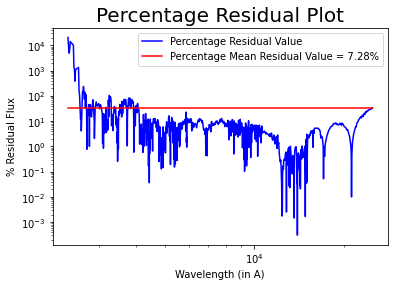

In [282]:
plt.loglog(m_wave,(np.abs(interpolated_flux-s_flux)/s_flux)*100,'b')
plt.loglog(m_wave, np.ones(m_wave.size)*np.mean((np.abs(interpolated_flux-s_flux)/s_flux)*100),'r')
plt.xlabel("Wavelength (in A)")
plt.ylabel("% Residual Flux")
plt.title("Percentage Residual Plot",fontsize=t_f)
plt.legend(["Percentage Residual Value","Percentage Mean Residual Value = {:0.2f}%".format(np.mean((np.abs(interpolated_flux[idx]-s_flux[idx])/s_flux[idx])*100))])
plt.savefig(data_directory+filename+"residual_plot.png")

In [283]:
w = csv.writer(open(data_directory+filename+"apparent_magnitude.csv", "w"))
for key, val in m.items():
    w.writerow([key, val])

In [284]:
w = csv.writer(open(data_directory+filename+"photometric_flux.csv", "w"))
for key, val in F.items():
    w.writerow([key, val])